<a href="https://colab.research.google.com/github/Tapish0305/Image-inpainting/blob/main/Image_Inpainting_CIFAR10_Dataset__github.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models
import copy
import cv2
from PIL import Image
import os
import seaborn as sns

# **Data Visualization**

In [2]:
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [3]:
trainset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = transform_train)
testset = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = transform_test)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
print(trainset)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [5]:
print(testset)

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )


In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True)

In [7]:
print(len(trainloader))

12500


In [11]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)

print(images[1].shape)
print(labels[1].item())

torch.Size([4, 3, 32, 32])
torch.Size([3, 32, 32])
0


In [12]:
img = images[1]
print(type(img))

<class 'torch.Tensor'>


In [13]:
npimg = img.numpy()
print(npimg.shape)
npimg = np.transpose(npimg, (1,2,0))
print(npimg.shape)

(3, 32, 32)
(32, 32, 3)


In [14]:
batch_size = 4

In [15]:
def imshow(img, title):
  npimg = img.numpy() / 2 + 0.5
  plt.figure(figsize = (batch_size, 1))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.title(title)
  plt.show()

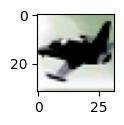

In [16]:
plt.figure(figsize = (1,1))
plt.imshow(npimg)
plt.show()

In [17]:
def show_batch_images(dataloader):
  images, labels = next(iter(dataloader))
  img = torchvision.utils.make_grid(images)
  imshow(img, title = [str(x.item()) for x in labels])

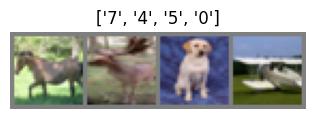

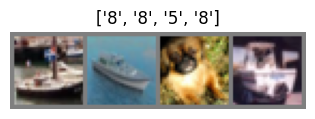

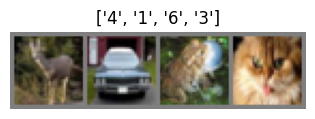

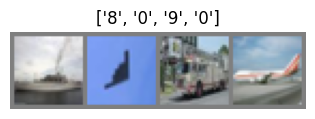

In [18]:
for i in range(4):
  show_batch_images(trainloader)

# **Data Pre Proccessing**

In [19]:
image_dims = (32, 32)
batch_size = 4

In [20]:
def imshow_masked(img):
  npimg = img.numpy()
  plt.figure(figsize = (3, 3))
  plt.axis('off')
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

In [21]:
class Dataset(torchvision.datasets.CIFAR10):
  def __init__(self, path, image_dims = (32, 32), n_channels = 3, train = True):
    super().__init__(path, train, download = True)
    self.n_classes = 10
    self.image_dims = image_dims
    self.n_channels = n_channels
    self.resize = transforms.Resize(image_dims)
    self.to_tensor = transforms.ToTensor()

  def __getitem__(self, index):
    image, label = super().__getitem__(index)

    Y_output = self.resize(image)
    X_input, X_mask = self.Create_Mask(Y_output)
    return self.to_tensor(X_input), self.to_tensor(X_mask), self.to_tensor(Y_output)

  def Create_Mask(self, image):
    mask = np.full((self.image_dims[0], self.image_dims[1], self.n_channels), 255, dtype = np.uint8)

    for _ in range(np.random.randint(1, 10)):
      x1, x2 = np.random.randint(1, self.image_dims[0]), np.random.randint(1, self.image_dims[0])
      y1, y2 = np.random.randint(1, self.image_dims[1]), np.random.randint(1, self.image_dims[1])
      thickness = np.random.randint(1, 3)

      cv2.line(mask, (x1, y1), (x2, y2), (1, 1, 1), thickness)

    image = np.asarray(image)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image, mask

In [22]:
Trainset = Dataset('./data', image_dims)
Testset = Dataset('./data', image_dims, train=False)

Files already downloaded and verified
Files already downloaded and verified


In [23]:
Trainloader = torch.utils.data.DataLoader(Trainset, batch_size = batch_size, shuffle = True)
Testloader = torch.utils.data.DataLoader(Testset, batch_size = batch_size, shuffle = False)

In [24]:
Train_dataiter = iter(Trainloader)

In [25]:
Test_dataiter = iter(Testloader)

In [27]:
X_in, X_mask, Y_out = next(Train_dataiter)
print(X_in.shape, X_mask.shape, Y_out.shape)

torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 32, 32]) torch.Size([4, 3, 32, 32])


Masked Image


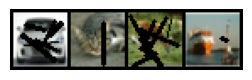

Masking Pattern


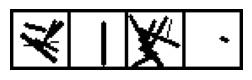

Original Image


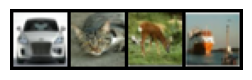

In [28]:
print('Masked Image')
imshow_masked(torchvision.utils.make_grid(X_in))
print('Masking Pattern')
imshow_masked(torchvision.utils.make_grid(X_mask))
print('Original Image')
imshow_masked(torchvision.utils.make_grid(Y_out))

# **Training**

In [29]:
class PartialConv(nn.Module):
    def __init__(self, in_filters, out_filters, kernel_size, strides=1, padding=0, dilation=1, groups=1, bias=True):
        super(PartialConv, self).__init__()

        padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.input_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=bias)
        self.mask_conv = nn.Conv2d(in_filters, out_filters, kernel_size, strides, padding, bias=False)

        self.window_size = kernel_size[0] * kernel_size[1]

        nn.init.constant_(self.mask_conv.weight, 1.0)

        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        mask_ratio = self.window_size / (output_mask + 1e-8)

        output_mask = torch.clamp(output_mask, 0, 1)

        mask_ratio = mask_ratio * output_mask

        output = output * mask_ratio

        output = output + output_bias

        return output, output_mask

In [30]:
class EncoderLayer(nn.Module):
    def __init__(self, in_filters, out_filters):
        super(EncoderLayer, self).__init__()
        self.p_conv_1 = PartialConv(in_filters, out_filters, (3, 3), strides=1)
        self.act_1 = nn.ReLU()
        self.p_conv_2 = PartialConv(out_filters, out_filters, (3, 3), strides=2)
        self.act_2 = nn.ReLU()

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1 = self.p_conv_1(inputs, masks)
        conv_out_1 = self.act_1(conv_out_1)

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [31]:
class DecoderLayer(nn.Module):
    def __init__(self, in_filters_1, in_filters_2):
        super(DecoderLayer, self).__init__()

        self.up_image = nn.Upsample(scale_factor=(2, 2))
        self.up_mask = nn.Upsample(scale_factor=(2, 2))

        self.p_conv_1 = PartialConv(in_filters_1 * 2, in_filters_1, (3, 3))
        self.act_1 = nn.LeakyReLU(negative_slope=0.2)
        self.p_conv_2 = PartialConv(in_filters_1, in_filters_2, (3, 3))
        self.act_2 = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, in_image, in_mask, share_image, share_mask):
        up_out = self.up_image(in_image)
        mask_out = self.up_mask(in_mask)

        concat_image = torch.cat([share_image, up_out], axis=1)
        concat_mask = torch.cat([share_mask, mask_out], axis=1)

        conv_out_1, mask_out_1 = self.p_conv_1(concat_image, concat_mask)
        conv_out_1 = self.act_1(conv_out_1)

        conv_out_2, mask_out_2 = self.p_conv_2(conv_out_1, mask_out_1)
        conv_out_2 = self.act_2(conv_out_2)

        return conv_out_1, mask_out_1, conv_out_2, mask_out_2

In [32]:
class InpaintingModel(nn.Module):
    def __init__(self, input_dims=(32, 32), num_channels=3):
        super(InpaintingModel, self).__init__()

        self.encoder_1 = EncoderLayer(num_channels, 32)
        self.encoder_2 = EncoderLayer(32, 64)
        self.encoder_3 = EncoderLayer(64, 128)
        self.encoder_4 = EncoderLayer(128, 256)

        self.decoder_1 = DecoderLayer(256, 128)
        self.decoder_2 = DecoderLayer(128, 64)
        self.decoder_3 = DecoderLayer(64, 32)
        self.decoder_4 = DecoderLayer(32, 3)

        self.output_layer = nn.Sequential(
            nn.Conv2d(3, 3, (3, 3), padding=1),
            nn.Sigmoid()
        )

    def forward(self, inputs, masks):
        conv_out_1, mask_out_1, conv_out_2, mask_out_2 = self.encoder_1(inputs, masks)
        conv_out_3, mask_out_3, conv_out_4, mask_out_4 = self.encoder_2(conv_out_2, mask_out_2)
        conv_out_5, mask_out_5, conv_out_6, mask_out_6 = self.encoder_3(conv_out_4, mask_out_4)
        conv_out_7, mask_out_7, conv_out_8, mask_out_8 = self.encoder_4(conv_out_6, mask_out_6)

        conv_out_9, mask_out_9, conv_out_10, mask_out_10 = self.decoder_1(conv_out_8, mask_out_8, conv_out_7, mask_out_7)
        conv_out_11, mask_out_11, conv_out_12, mask_out_12 = self.decoder_2(conv_out_6, mask_out_6, conv_out_5, mask_out_5)
        conv_out_13, mask_out_13, conv_out_14, mask_out_14 = self.decoder_3(conv_out_4, mask_out_4, conv_out_3, mask_out_3)
        conv_out_15, mask_out_15, conv_out_16, mask_out_16 = self.decoder_4(conv_out_2, mask_out_2, conv_out_1, mask_out_1)

        outputs = self.output_layer(conv_out_16)
        return outputs

In [33]:
def jaccard_coeff(dataloader):
  for (X_input, X_mask, Y_output) in dataloader:
    X_input, X_mask, Y_output = X_input, X_mask, Y_output
    outputs = model(X_input, X_mask)
    eps = 1e-15
    outputs = outputs.view(-1)
    Y_output = Y_output.view(-1)
    intersection = (outputs * Y_output).sum()
    union = (outputs.sum() + Y_output.sum()) - intersection
  return (intersection / (union + eps))

In [34]:
model = InpaintingModel()

In [35]:
loss_fn = nn.MSELoss()
opt = optim.Adam(model.parameters())

Min loss 0.05
Iteration: 0/12500, Loss: 0.05
Min loss 0.05
Min loss 0.04
Min loss 0.03
Min loss 0.02
Iteration: 100/12500, Loss: 0.06
Iteration: 200/12500, Loss: 0.04
Min loss 0.02
Min loss 0.01
Iteration: 300/12500, Loss: 0.02
Min loss 0.01
Min loss 0.01
Iteration: 400/12500, Loss: 0.01
Iteration: 500/12500, Loss: 0.01
Iteration: 600/12500, Loss: 0.01
Iteration: 700/12500, Loss: 0.01
Iteration: 800/12500, Loss: 0.02
Iteration: 900/12500, Loss: 0.01
Iteration: 1000/12500, Loss: 0.01
Iteration: 1100/12500, Loss: 0.02
Iteration: 1200/12500, Loss: 0.01
Min loss 0.01
Iteration: 1300/12500, Loss: 0.01
Min loss 0.01
Iteration: 1400/12500, Loss: 0.01
Min loss 0.01
Iteration: 1500/12500, Loss: 0.01
Iteration: 1600/12500, Loss: 0.01
Iteration: 1700/12500, Loss: 0.01
Iteration: 1800/12500, Loss: 0.02
Iteration: 1900/12500, Loss: 0.01
Iteration: 2000/12500, Loss: 0.02
Iteration: 2100/12500, Loss: 0.01
Min loss 0.00
Min loss 0.00
Iteration: 2200/12500, Loss: 0.02
Iteration: 2300/12500, Loss: 0.01


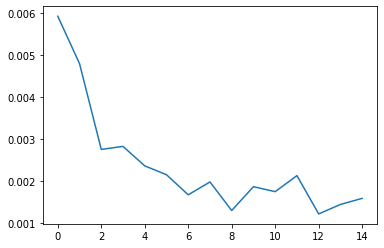

CPU times: user 29min 45s, sys: 2min 43s, total: 32min 28s
Wall time: 32min 37s


In [ ]:
%%time
loss_epoch_arr = []
max_epochs = 15

min_loss = 1000

n_iters = np.ceil(50000/batch_size)
for epoch in range(max_epochs):
    model.train()
    for i, (X_input, X_mask, Y_output) in enumerate(Trainloader, 0):

        X_input, X_mask, Y_output = X_input X_mask, Y_output

        opt.zero_grad()

        outputs = model(X_input, X_mask)
        loss = loss_fn(Y_output, outputs)
        loss.backward()

        opt.step()

        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(model.state_dict())
            print('Min loss %0.2f' % min_loss)

        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.002f' % (i, n_iters, loss.item()))

        del X_input, X_mask, Y_output

    loss_epoch_arr.append(loss.item())

plt.plot(loss_epoch_arr)
plt.show()

In [ ]:
model.load_state_dict(best_model)

<All keys matched successfully>

In [ ]:
print(model)

InpaintingModel(
  (encoder_1): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    )
    (act_2): ReLU()
  )
  (encoder_2): EncoderLayer(
    (p_conv_1): PartialConv(
      (input_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (mask_conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (act_1): ReLU()
    (p_conv_2): PartialConv(
      (input_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (mask_conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=Fals

In [ ]:
weight_layer0 = list(model.parameters())[0].cpu()
weight_layer0 = weight_layer0.data.numpy()

In [ ]:
print(weight_layer0.shape)

(32, 3, 3, 3)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


[]

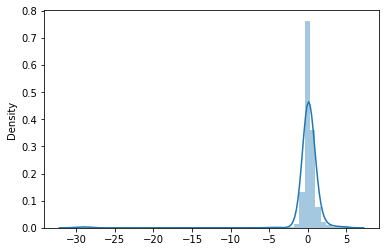

In [ ]:
sns.distplot(weight_layer0.ravel())
plt.plot()

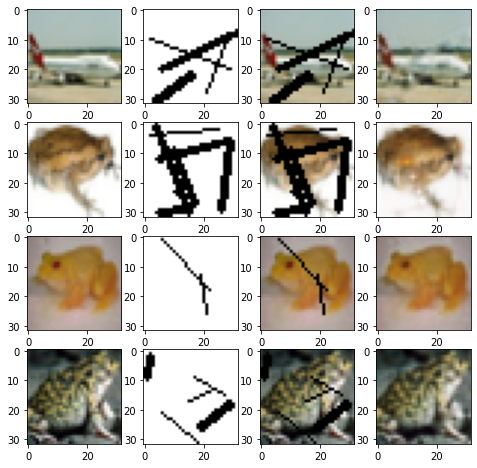

In [ ]:
sample_inputs, sample_masks, sample_truths = Train_dataiter.next()
sample_inputs, sample_masks = sample_inputs, sample_masks

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))

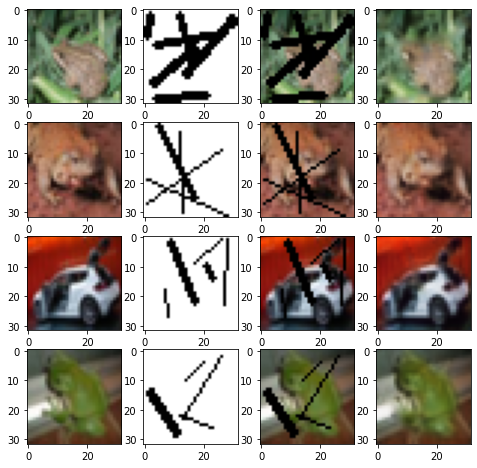

In [ ]:
sample_inputs, sample_masks, sample_truths = Test_dataiter.next()
sample_inputs, sample_masks = sample_inputs, sample_masks

model.eval()
with torch.no_grad():
    sample_preds = model(sample_inputs, sample_masks)

fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(8, 8))

sample_inputs, sample_masks = sample_inputs.cpu(), sample_masks.cpu()
for i in range(4):
    axs[i][0].imshow(np.transpose(sample_truths[i], (1, 2, 0)))
    axs[i][1].imshow(np.transpose(sample_masks[i], (1, 2, 0)))
    axs[i][2].imshow(np.transpose(sample_inputs[i],(1, 2, 0)))
    axs[i][3].imshow(np.transpose(sample_preds[i].cpu(), (1, 2, 0)))